# Kaggle Heart Disease Prediction - EDA & Baseline

## 1. ライブラリのインポート

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# 表示設定
pd.set_option('display.max_columns', None)
%matplotlib inline

## 2. データの読み込みと確認

In [2]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
sample_sub = pd.read_csv('data/sample_submission.csv')

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

Train shape: (630000, 15)
Test shape: (270000, 14)


In [3]:
# データの先頭を表示
display(train_df.head())
display(test_df.head())

,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,Presence
1,1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,Absence
2,2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,Absence
3,3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,Absence
4,4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,Presence


,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium
0,630000,58,1,3,120,288,0,2,145,1,0.8,2,3,3
1,630001,55,0,2,120,209,0,0,172,0,0.0,1,0,3
2,630002,54,1,4,120,268,0,0,150,1,0.0,2,3,7
3,630003,44,0,3,112,177,0,0,168,0,0.9,1,0,3
4,630004,43,1,1,138,267,0,0,163,0,1.8,2,0,7


## 3. 欠損値の確認

In [4]:
print("Train Missing values:")
print(train_df.isnull().sum()[train_df.isnull().sum() > 0])
print("\nTest Missing values:")
print(test_df.isnull().sum()[test_df.isnull().sum() > 0])

Train Missing values:
Series([], dtype: int64)

Test Missing values:
Series([], dtype: int64)


## 4. データ分析 (簡易EDA)
ターゲット変数 `Heart Disease` の分布を確認します。

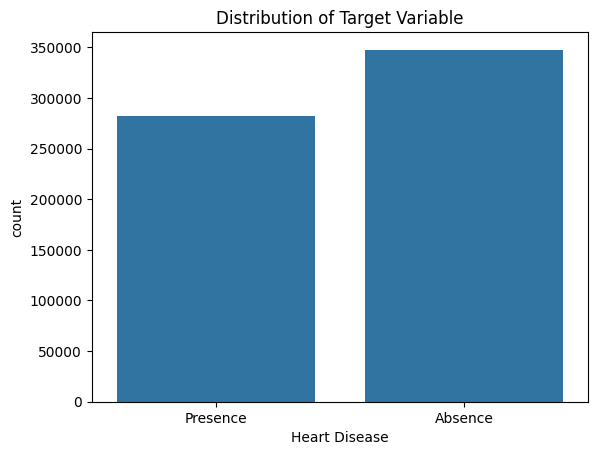

In [5]:
sns.countplot(x='Heart Disease', data=train_df)
plt.title('Distribution of Target Variable')
plt.show()

## 5. 前処理 & モデル構築 (ベースライン)

In [6]:
# ターゲット変数の変換 (Presence -> 1, Absence -> 0)
target_mapping = {'Presence': 1, 'Absence': 0}
train_df['Heart Disease_encoded'] = train_df['Heart Disease'].map(target_mapping)

# 特徴量とターゲットの分離
drop_cols = ['id', 'Heart Disease', 'Heart Disease_encoded']
X = train_df.drop(drop_cols, axis=1)
y = train_df['Heart Disease_encoded']

# テストデータ
X_test_sub = test_df.drop(['id'], axis=1)

# 学習用と検証用に分割
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")

Training samples: 504000
Validation samples: 126000


In [7]:
# モデル学習 (Random Forest)
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# 評価
y_pred_val = model.predict(X_val)
acc = accuracy_score(y_val, y_pred_val)

print(f"Validation Accuracy: {acc:.4f}")
print(classification_report(y_val, y_pred_val))

Validation Accuracy: 0.8805
              precision    recall  f1-score   support

           0       0.89      0.90      0.89     69564
           1       0.87      0.86      0.87     56436

    accuracy                           0.88    126000
   macro avg       0.88      0.88      0.88    126000
weighted avg       0.88      0.88      0.88    126000



## 6. 提出ファイルの作成

In [8]:
predictions = model.predict(X_test_sub)

submission = pd.DataFrame({
    'id': test_df['id'],
    'Heart Disease': predictions
})

submission.head()

,id,Heart Disease
0,630000,1
1,630001,0
2,630002,1
3,630003,0
4,630004,0


In [9]:
submission.to_csv('submission.csv', index=False)
print("Saved submission.csv")

Saved submission.csv


## 7. 特徴量重要度の確認
Random Forestを使って、どの特徴量が予測に重要だったかを確認します。これにより、データの理解を深めます。

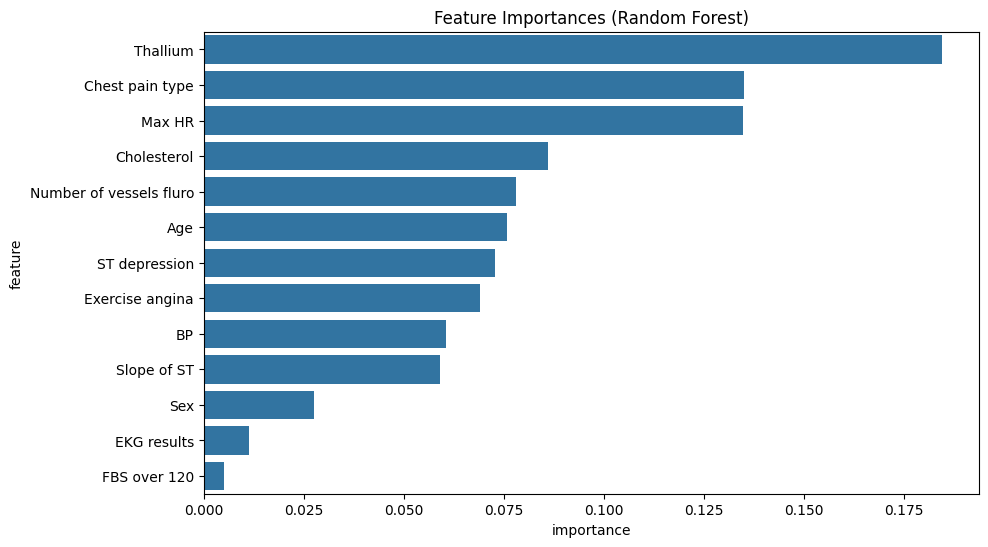

In [10]:
# 特徴量の重要度を取得
importances = model.feature_importances_
feature_names = X.columns

# データフレーム化してソート
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importances = feature_importances.sort_values('importance', ascending=False)

# 可視化
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('Feature Importances (Random Forest)')
plt.show()

## 8. モデルの高度化: LightGBMの導入
より高性能な勾配ブースティング決定木 (GBDT) アルゴリズムである **LightGBM** を使用してみます。\nまた、評価の信頼性を高めるために、データを単純に2つに分けるのではなく、**5分割交差検証 (Stratified K-Fold CV)** を行います。\n\n※ LightGBMをインストールしていない場合は、ターミナルで `pip install lightgbm` を実行してください。

In [11]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold

# LightGBMのハイパーパラメータ (基本的な設定)
params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'random_state': 42
}

# 交差検証の設定
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = []
cv_preds = [] # テストデータに対する予測を格納するリスト (後で平均する)

# 交差検証の実行
for i, (train_index, val_index) in enumerate(kf.split(X, y)):
    X_train_cv, X_val_cv = X.iloc[train_index], X.iloc[val_index]
    y_train_cv, y_val_cv = y.iloc[train_index], y.iloc[val_index]
    
    # LightGBM用データセット
    lgb_train = lgb.Dataset(X_train_cv, y_train_cv)
    lgb_val = lgb.Dataset(X_val_cv, y_val_cv, reference=lgb_train)
    
    # 学習
    model_lgb = lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_train, lgb_val],
        num_boost_round=1000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(0) # ログ出力を抑制 (出したい場合は 100 など)
        ]
    )
    
    # 検証データでの評価
    val_preds = (model_lgb.predict(X_val_cv) > 0.5).astype(int)
    acc = accuracy_score(y_val_cv, val_preds)
    cv_scores.append(acc)
    print(f"Fold {i+1} Accuracy: {acc:.4f}")
    
    # テストデータの予測を蓄積
    cv_preds.append(model_lgb.predict(X_test_sub))

print(f"\nAverage CV Accuracy: {np.mean(cv_scores):.4f}")

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[344]	training's binary_error: 0.10877	valid_1's binary_error: 0.109944
Fold 1 Accuracy: 0.8901
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[183]	training's binary_error: 0.109532	valid_1's binary_error: 0.112873
Fold 2 Accuracy: 0.8871
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[235]	training's binary_error: 0.109385	valid_1's binary_error: 0.11131
Fold 3 Accuracy: 0.8887
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[228]	training's binary_error: 0.109286	valid_1's binary_error: 0.112087
Fold 4 Accuracy: 0.8879
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[158]	training's binary_error: 0.110405	valid_1's binary_error: 0.111087
Fold 5 Accuracy: 0.8889

Average CV Accuracy: 0.8885


In [ ]:
# 提出ファイルの作成 (各Foldの予測の平均をとる)
final_preds = np.mean(cv_preds, axis=0)
final_preds_binary = (final_preds > 0.5).astype(int)

submission_lgb = pd.DataFrame({
    'id': test_df['id'],
    'Heart Disease': final_preds_binary
})

submission_lgb.to_csv('submission_lgb.csv', index=False)
print("Saved submission_lgb.csv")

## 9. カテゴリ変数の明示的指定
`Thallium` と `Chest pain type` は数値として記録されていますが、意味的にはカテゴリ変数です。
これらを `category` 型に変換してから再度 LightGBM で学習させることで、モデルがより適切にパターンを学習できる可能性があります。

In [22]:
# カテゴリ変数として変換
cat_cols = ['Sex', 'Chest pain type', 'FBS over 120', 'EKG results', 
                        'Exercise angina', 'Thallium', 'Slope of ST']
num_cols = ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression', 'Number of vessels fluro']
for col in cat_cols:
    X[col] = X[col].astype('category')
    X_test_sub[col] = X_test_sub[col].astype('category')

for num in num_cols:
    X[num] = X[num].astype('float')
    X_test_sub[num] = X_test_sub[num].astype('float')

# データ型の確認
print("Categorical columns:", cat_cols)
print("Numerical columns:", num_cols)
print("\ndtypes:\n", X.dtypes)

Categorical columns: ['Sex', 'Chest pain type', 'FBS over 120', 'EKG results', 'Exercise angina', 'Thallium', 'Slope of ST']
Numerical columns: ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression', 'Number of vessels fluro']

dtypes:
 Age                         float64
Sex                        category
Chest pain type            category
BP                          float64
Cholesterol                 float64
FBS over 120               category
EKG results                category
Max HR                      float64
Exercise angina            category
ST depression               float64
Slope of ST                category
Number of vessels fluro     float64
Thallium                   category
dtype: object


In [16]:
# 再度 LightGBM で交差検証 (カテゴリ変数として扱われる)
cv_scores_cat = []
cv_preds_cat = []

print("Training LightGBM with categorical features...")

for i, (train_index, val_index) in enumerate(kf.split(X, y)):
    X_train_cv, X_val_cv = X.iloc[train_index], X.iloc[val_index]
    y_train_cv, y_val_cv = y.iloc[train_index], y.iloc[val_index]
    
    # カテゴリ変数の扱いはLightGBMが自動でdetectします (pandas category型のため)
    lgb_train = lgb.Dataset(X_train_cv, y_train_cv)
    lgb_val = lgb.Dataset(X_val_cv, y_val_cv, reference=lgb_train)
    
    model_lgb_cat = lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_train, lgb_val],
        num_boost_round=1000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(100)
        ]
    )
    
    val_preds = (model_lgb_cat.predict(X_val_cv) > 0.5).astype(int)
    acc = accuracy_score(y_val_cv, val_preds)
    cv_scores_cat.append(acc)
    print(f"Fold {i+1} Accuracy: {acc:.4f}")
    
    cv_preds_cat.append(model_lgb_cat.predict(X_test_sub))

print(f"\nAverage CV Accuracy (Category): {np.mean(cv_scores_cat):.4f}")

Training LightGBM with categorical features...
Training until validation scores don't improve for 50 rounds
[100]	training's binary_error: 0.111466	valid_1's binary_error: 0.111103
[200]	training's binary_error: 0.11019	valid_1's binary_error: 0.110365
Early stopping, best iteration is:
[246]	training's binary_error: 0.109627	valid_1's binary_error: 0.110103
Fold 1 Accuracy: 0.8899
Training until validation scores don't improve for 50 rounds
[100]	training's binary_error: 0.110845	valid_1's binary_error: 0.11304
[200]	training's binary_error: 0.109492	valid_1's binary_error: 0.11273
[300]	training's binary_error: 0.108534	valid_1's binary_error: 0.112468
[400]	training's binary_error: 0.107577	valid_1's binary_error: 0.112262
Early stopping, best iteration is:
[417]	training's binary_error: 0.107383	valid_1's binary_error: 0.112222
Fold 2 Accuracy: 0.8878
Training until validation scores don't improve for 50 rounds
[100]	training's binary_error: 0.110964	valid_1's binary_error: 0.11170

In [ ]:
# 新しいモデルでの提出ファイル作成
final_preds_cat = np.mean(cv_preds_cat, axis=0)
final_preds_binary_cat = (final_preds_cat > 0.5).astype(int)

submission_lgb_cat = pd.DataFrame({
    'id': test_df['id'],
    'Heart Disease': final_preds_binary_cat
})

submission_lgb_cat.to_csv('submission_lgb_cat.csv', index=False)
print("Saved submission_lgb_cat.csv")

## 10. 特徴量エンジニアリング (本来の最重要ステップ)
パラメータチューニングの前に（あるいは並行して）、データそのものの表現力を高める「特徴量エンジニアリング」を行います。
ここでは、医学的な知見やデータの組み合わせから新しい特徴量を作成します。

**作成する特徴量:**
1. **Rate Pressure Product (RPP)**: `Max HR` * `BP`。心筋酸素消費量の指標として使われることがあります。
2. **Age Group**: 年齢を年代ごとにビン分割します。

In [ ]:
# データの再取得 (コピー)
X_fe = train_df.drop(['id', 'Heart Disease', 'Heart Disease_encoded'], axis=1).copy()
X_test_fe = test_df.drop(['id'], axis=1).copy()
y_fe = train_df['Heart Disease_encoded']

# 1. Rate Pressure Product (RPP)
X_fe['RPP'] = X_fe['Max HR'] * X_fe['BP']
X_test_fe['RPP'] = X_test_fe['Max HR'] * X_test_fe['BP']

# 2. Age Group (年代)
# pd.cut で区切る
X_fe['Age_Group'] = pd.cut(X_fe['Age'], bins=[0, 40, 50, 60, 70, 100], labels=[0, 1, 2, 3, 4])
X_test_fe['Age_Group'] = pd.cut(X_test_fe['Age'], bins=[0, 40, 50, 60, 70, 100], labels=[0, 1, 2, 3, 4])

# カテゴリ変数の型変換 (先ほどと同じ)
cat_cols_fe = ['Thallium', 'Chest pain type', 'Age_Group'] # Age_Groupもカテゴリ扱い
for col in cat_cols_fe:
    X_fe[col] = X_fe[col].astype('category')
    X_test_fe[col] = X_test_fe[col].astype('category')

print("New columns:", X_fe.columns.tolist())

In [ ]:
# 新しい特徴量を使って学習 (基本パラメータを使用)
cv_preds_fe = []
cv_scores_fe = []

print("Training with Feature Engineering...")

for i, (train_index, val_index) in enumerate(kf.split(X_fe, y_fe)):
    X_train_cv, X_val_cv = X_fe.iloc[train_index], X_fe.iloc[val_index]
    y_train_cv, y_val_cv = y_fe.iloc[train_index], y_fe.iloc[val_index]
    
    lgb_train = lgb.Dataset(X_train_cv, y_train_cv)
    lgb_val = lgb.Dataset(X_val_cv, y_val_cv, reference=lgb_train)
    
    # カテゴリ変数のwarningが出る場合があるので、verboseを調整
    model_fe = lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_train, lgb_val],
        num_boost_round=1000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(100)
        ]
    )
    
    val_preds = (model_fe.predict(X_val_cv) > 0.5).astype(int)
    acc = accuracy_score(y_val_cv, val_preds)
    cv_scores_fe.append(acc)
    print(f"Fold {i+1} Accuracy: {acc:.4f}")
    
    cv_preds_fe.append(model_fe.predict(X_test_fe))

print(f"\nAverage CV Accuracy (FE): {np.mean(cv_scores_fe):.4f}")

# 提出ファイル
final_preds_fe = np.mean(cv_preds_fe, axis=0)
final_preds_binary_fe = (final_preds_fe > 0.5).astype(int)

submission_fe = pd.DataFrame({
    'id': test_df['id'],
    'Heart Disease': final_preds_binary_fe
})

submission_fe.to_csv('submission_lgb_fe.csv', index=False)
print("Saved submission_lgb_fe.csv")